In [1]:
!git clone 'https://github.com/aakashvardhan/Transformers-Collab.git'

Cloning into 'Transformers-Collab'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 352 (delta 71), reused 316 (delta 35), pack-reused 0
Receiving objects: 100% (352/352), 13.50 MiB | 10.64 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
%cd Transformers-Collab

/content/Transformers-Collab


In [4]:
from utils import (create_dataloader,
                   get_img_batch,
                   show_img,
                   patchify_img,
                   show_conv2d_feature_maps)
from config import VITConfig

In [5]:
config = VITConfig()

train_dataloader, test_dataloader, class_names = create_dataloader(config)

In [7]:
image, label = get_img_batch(train_dataloader)

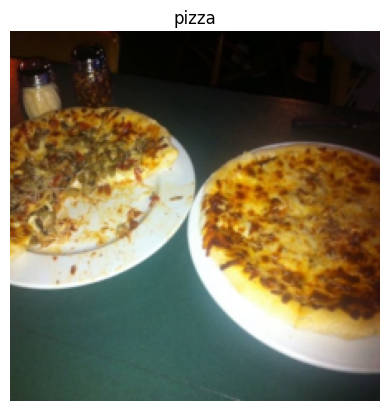

<Figure size 640x480 with 0 Axes>

In [8]:
show_img(image, label, class_names)

Number of patches per row: 14.0            
Number of patches per column: 14.0            
Total patches: 196.0            
Patch size: 16 pixels x 16 pixels


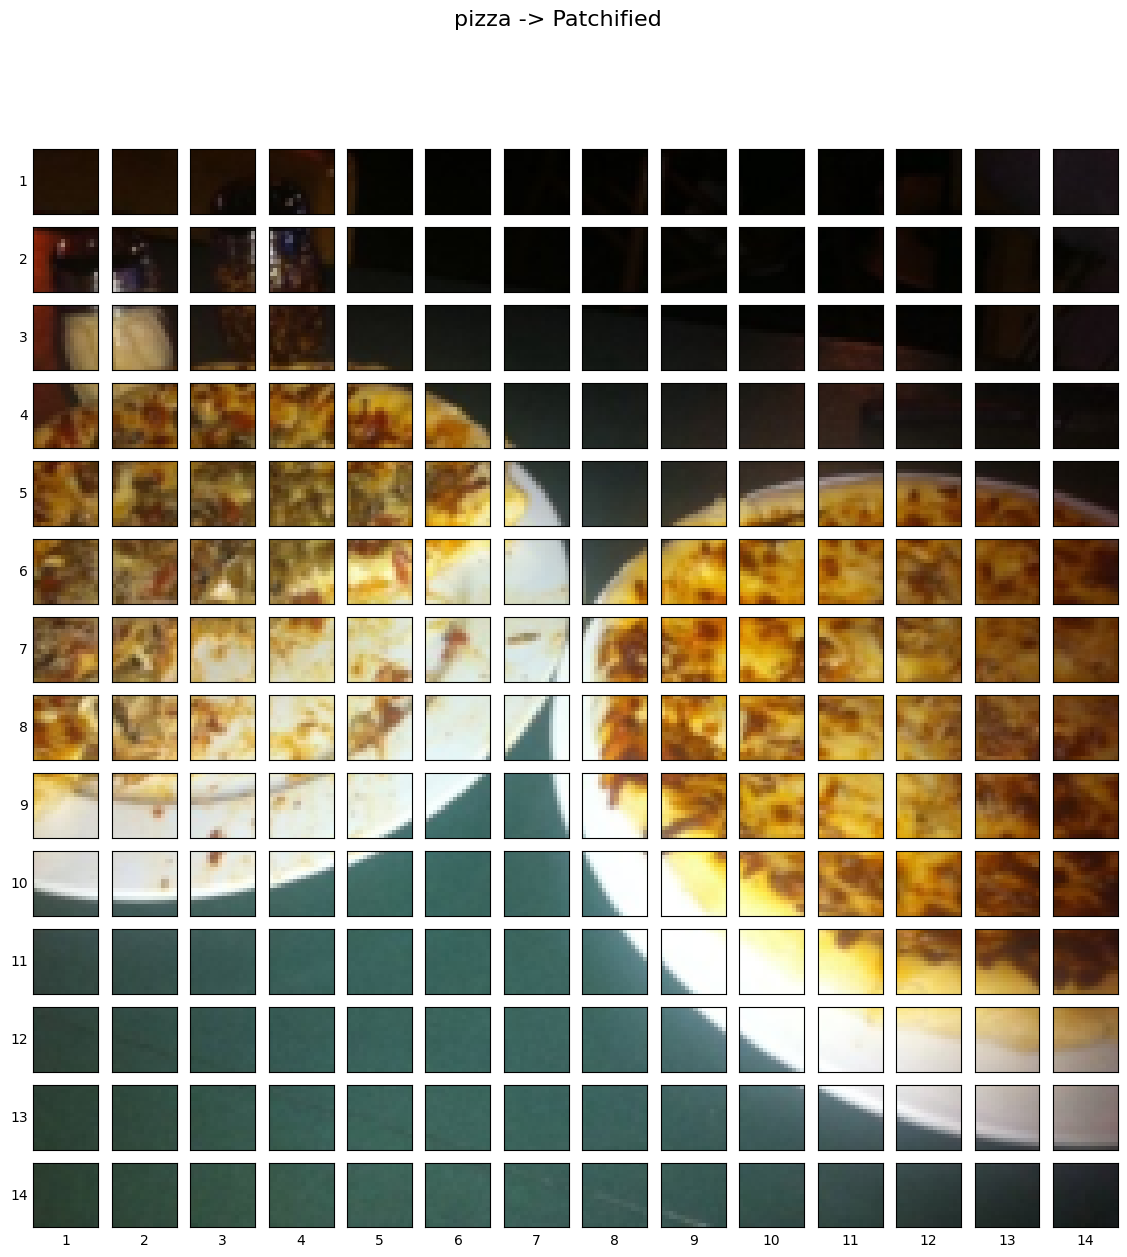

<Figure size 640x480 with 0 Axes>

In [9]:
patchify_img(image, label, class_names, config)

Showing random convolutional feature maps from indexes: [499, 640, 676, 534, 168]


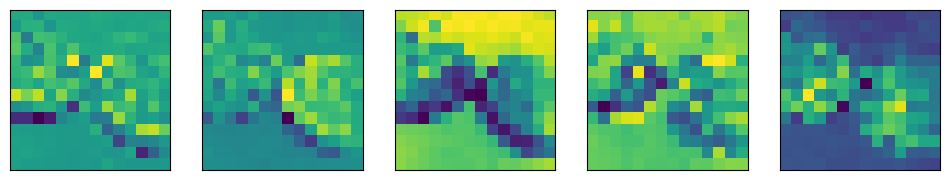

In [10]:
show_conv2d_feature_maps(image, config)

In [ ]:
show_flattened_feature_map(image, config)

In [ ]:
from models.transformer import VIT

In [ ]:
vit = VIT(num_classes=len(class_names))

In [ ]:
get_vit_model_summary(vit)

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=config.lr, # Base LR from Table 3 for ViT-* ImageNet-1k
                            betas=config.betas, # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                            weight_decay=config.weight_decay) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=config.epoch,
                    device=config.device)